In [ ]:

import kagglehub
aryashah2k_breast_ultrasound_images_dataset_path = kagglehub.dataset_download('aryashah2k/breast-ultrasound-images-dataset')

print('Data source import complete.')


100%|██████████| 195M/195M [00:02<00:00, 99.7MB/s]

Extracting files...


Data source import complete.


UNet

In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

In [ ]:
paths = glob(f'{aryashah2k_breast_ultrasound_images_dataset_path}/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [ ]:
sorted(glob(f'{aryashah2k_breast_ultrasound_images_dataset_path}/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

*** Some images have 2 or more masks. Combine them into one image.**

<a id="3.2"></a>
## <span style="color:#08bf2c;"> Loading data </span>

In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
size = 128   # image size: 128x128
X, y = load_data(root_path = f'{aryashah2k_breast_ultrasound_images_dataset_path}/Dataset_BUSI_with_GT/*/*', size = size)

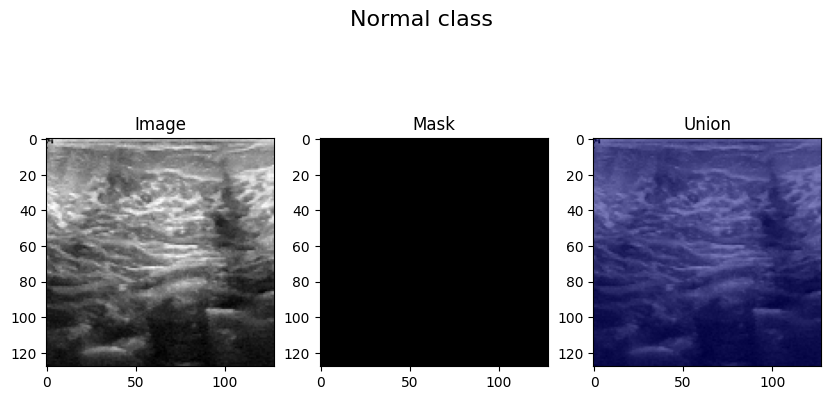

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

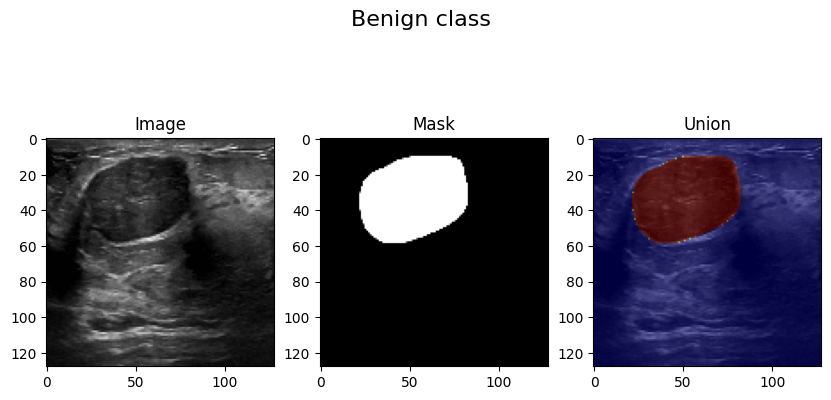

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

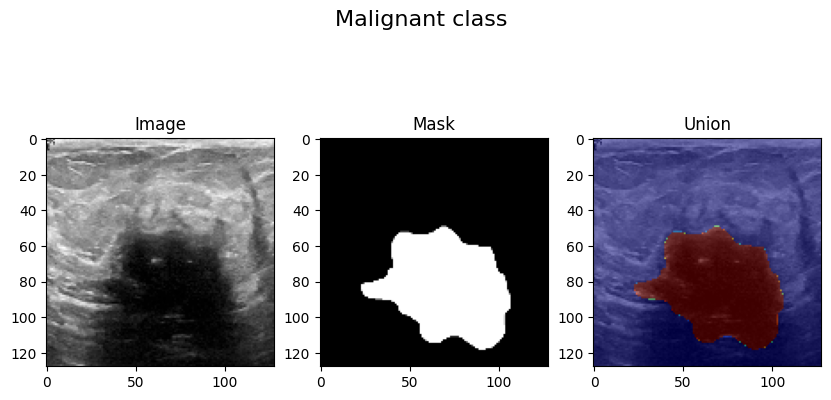

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

<a id="4.2"></a>
## <span style="color:#08bf2c;"> Average view of masks each class </span>

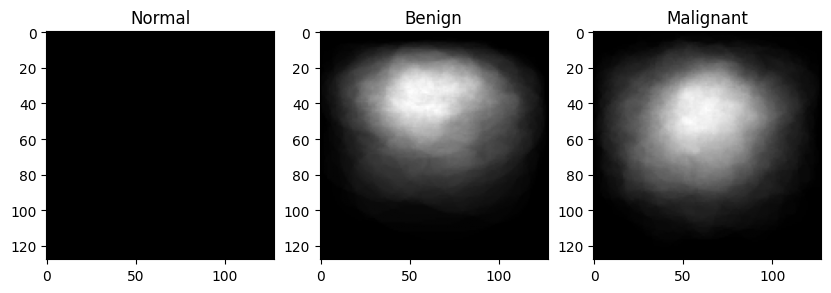

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

### <span style="color:#2981d9;"> Prepare data to modeling </span>

In [ ]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


### <span style="color:#2981d9;"> Train-test split </span>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


### <span style="color:#2981d9;"> Conv block </span>

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### <span style="color:#2981d9;"> Encoder block </span>

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### <span style="color:#2981d9;"> Decoder block </span>

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

### <span style="color:#2981d9;"> Build model </span>

In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

### <span style="color:#2981d9;"> Model plotting </span>

### <span style="color:#2981d9;"> Model summary </span>

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

<a id="6.2"></a>
## <span style="color:#08bf2c;"> Training </span>

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.8119 - loss: 0.6470 - val_accuracy: 0.8926 - val_loss: 0.3774
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 377ms/step - accuracy: 0.9012 - loss: 0.3475 - val_accuracy: 0.8926 - val_loss: 0.3517
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.9072 - loss: 0.3222 - val_accuracy: 0.8926 - val_loss: 0.3386
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.8998 - loss: 0.3201 - val_accuracy: 0.8926 - val_loss: 0.4093
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9080 - loss: 0.3219 - val_accuracy: 0.8926 - val_loss: 0.3279
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.9050 - loss: 0.3016 - val_accuracy: 0.8926 - val_loss: 0.3376
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - accuracy: 0.9039 - loss: 0.2951 - val_accuracy: 0.8942 - val_loss: 0.2782
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.8990 - loss: 0.2543 - val

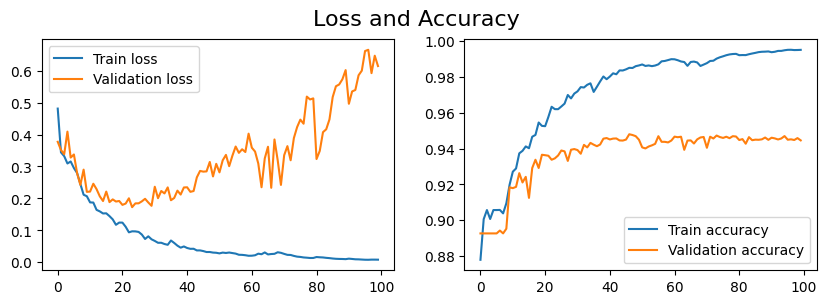

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

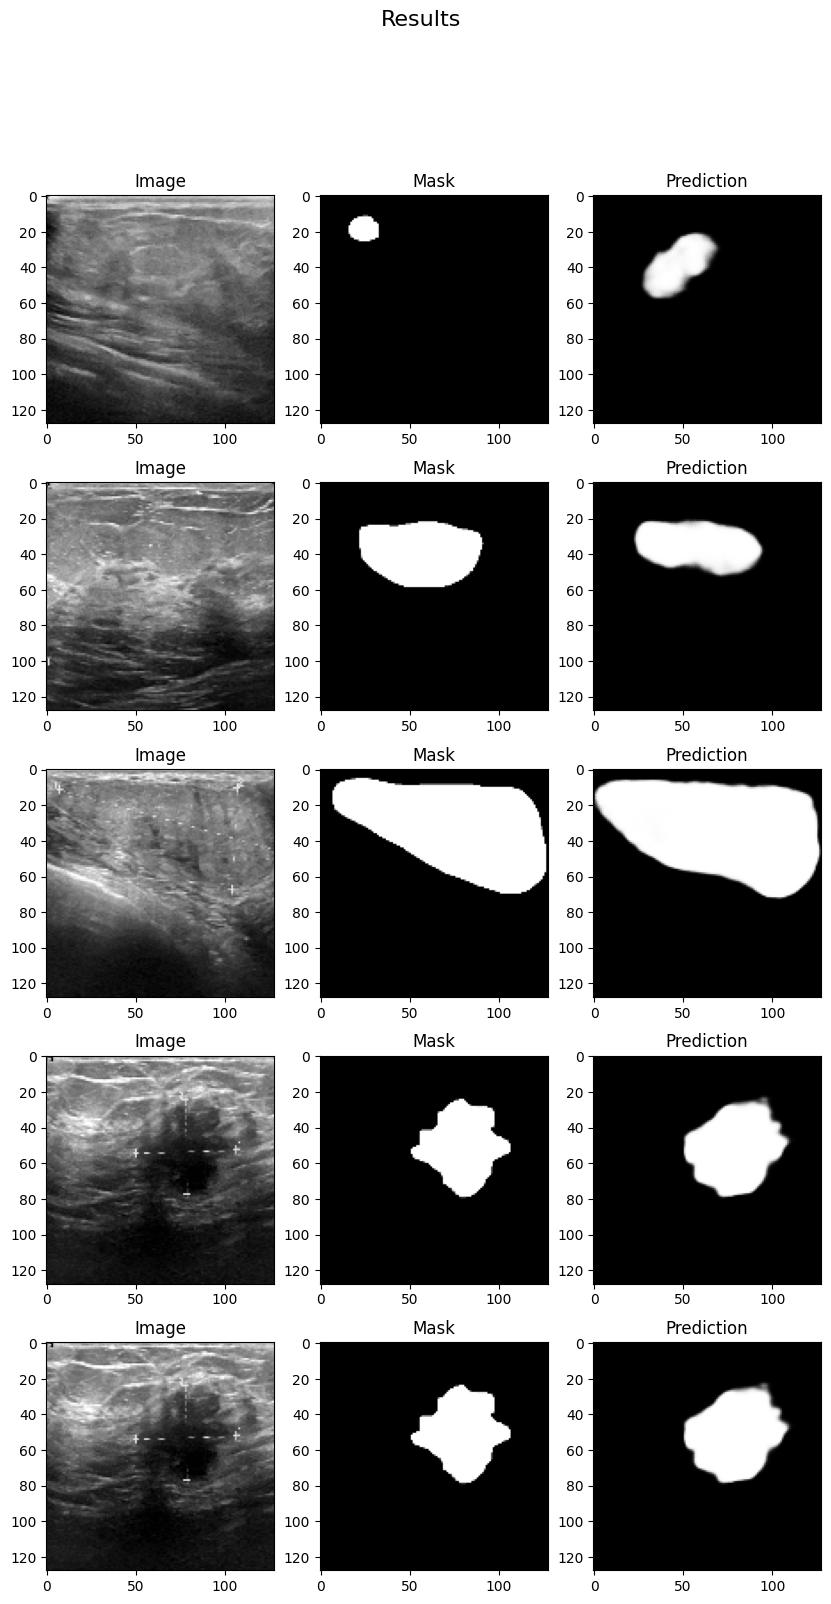

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.7480559
Precision Score = 0.632
Recall Score = 0.818
F1 Score = 0.713
